# *1. Загрузка библиотек*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling as pp
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix

In [2]:
RANDOM_STATE = 5

# *2. Загрузка данных*

In [3]:
data_dir = '../input/sf-dst-scoring/'
train_df = pd.read_csv(data_dir+'train.csv')
test_df = pd.read_csv(data_dir+'test.csv')

In [4]:
# объединяем тестовую и обучающую выборки в один датафрейм
train_df['test'] = 0
test_df['test'] = 1
df = pd.concat([train_df, test_df], ignore_index=True)

# *3. Обзор и анализ данных* 

In [5]:
# колличество позиций в тестовой и обучающей выборке
df['test'].value_counts()

0    73799
1    36349
Name: test, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## *DataSet fields*


    client_id - идентификатор клиента
    education - уровень образования
    sex - пол заемщика
    age - возраст заемщика
    car - флаг наличия автомобиля
    car_type - флаг автомобиля иномарки
    decline_app_cnt - количество отказанных прошлых заявок
    good_work - флаг наличия “хорошей” работы
    bki_request_cnt - количество запросов в БКИ
    home_address - категоризатор домашнего адреса
    work_address - категоризатор рабочего адреса
    income - доход заемщика
    foreign_passport - наличие загранпаспорта
    sna - связь заемщика с клиентами банка
    first_time - давность наличия информации о заемщике
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    app_date - дата подачи заявки
    default - флаг дефолта по кредиту

In [7]:
# анализ данных с использованием библиотеки ProfileReport
df_pp = pp.ProfileReport(df)
df_pp

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# *4. Обработка и преобразование данных*

### **default** - целевое значение

In [8]:

df['default'].value_counts()

0.0    64427
1.0     9372
Name: default, dtype: int64

Иммется дисбаланс целевой переменной 1:7, для упрощения обработки данный, а также oversampling/undersempling, отсортируем выборку:<br>
0-9372 - выборка со значением default=1<br>
9373-73798 - выборка со значением default=0<br>
73799-110148 - тестовая выборка

In [9]:
df = pd.concat([df[df['default'] == 1], df[df['default']==0], df[df['test']==1]], ignore_index=True)

### **client_id** - уникальные значения, соответствуют порядковому номеру клиента, параметр не будет использоваться при обучении модели

### **app_data** - дата в формате строки. Будет приобразована в формат DateTime, для дальнейшей генерации новых признаков.

In [10]:
df['app_date'].unique()

array(['02FEB2014', '28FEB2014', '11FEB2014', '02MAR2014', '25FEB2014',
       '17MAR2014', '24FEB2014', '03FEB2014', '05FEB2014', '13MAR2014',
       '30JAN2014', '31MAR2014', '26JAN2014', '15MAR2014', '18MAR2014',
       '08JAN2014', '19APR2014', '30APR2014', '15JAN2014', '10FEB2014',
       '20JAN2014', '17FEB2014', '19JAN2014', '26APR2014', '04APR2014',
       '12MAR2014', '14MAR2014', '18JAN2014', '12FEB2014', '27JAN2014',
       '23JAN2014', '12JAN2014', '12APR2014', '07JAN2014', '16APR2014',
       '22MAR2014', '06MAR2014', '04FEB2014', '01APR2014', '25MAR2014',
       '05MAR2014', '22FEB2014', '30MAR2014', '04MAR2014', '22APR2014',
       '11MAR2014', '16JAN2014', '25APR2014', '14FEB2014', '06APR2014',
       '29JAN2014', '31JAN2014', '29MAR2014', '08APR2014', '03APR2014',
       '15FEB2014', '20MAR2014', '02APR2014', '21FEB2014', '09APR2014',
       '19MAR2014', '07APR2014', '08MAR2014', '28APR2014', '25JAN2014',
       '04JAN2014', '21JAN2014', '26FEB2014', '15APR2014', '16MA

In [11]:
# преобразование значений в DateTime формат
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')

создание новых признаков:<br>
-season - сезон<br>
-month - месяц<br>
-weekend - выходные<br>

In [12]:
df['app_month'] = df['app_date'].apply(lambda x: x.month)
df['app_season']= df['app_date'].apply(lambda x: np.ceil(x.month/3.0))
df['app_weekend'] = df['app_date'].apply(lambda x: x.weekday()>=5)

### **education** - категорийный признак. Заполним пропуски самым частым значением. Преобразуем значения в числовые.

In [13]:
#заполнение пустых значений
df['education'] = df['education'].fillna('SCH')
#преобразование в числовые значения в соответствии с их весом
df['education'] = df['education'].apply(lambda x: {'SCH':0, 
                                                       'GRD':1,
                                                       'UGR':2,
                                                       'PGR':3,
                                                       'ACD':4
                                                      }.get(x, 0))

### **sex, car, car_type, good_work, foreign_passport** - бинарные значения. Выделим, для дальнейшего преобразования.

In [14]:
#группировка бинарных значений
bool_var = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'app_weekend']
#кодирование бинарных значений
le = LabelEncoder()
for item in bool_var:
    df[item] = le.fit_transform(df[item])

In [15]:
X_bool = df[bool_var].values #формирование конечной матрицы бинарных значений

### **app_month, app_season, app_weekend, education, home_address, work_address, sna, first_time** - категориальные признаки. Выделим для дальнейшего преобразования.

In [16]:
#группировка категорийных значений
cat_var = ['app_month', 'app_season', 'app_weekend', 'education', 'home_address', 'work_address',
           'sna', 'first_time']

<AxesSubplot:>

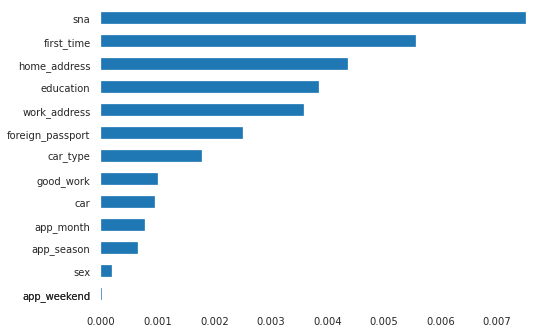

In [17]:
#оценка значимости категорийных значений
imp_cat = pd.Series(mutual_info_classif(df[bool_var+cat_var][df['test']==0], df['default'].dropna(), discrete_features=True),
          index=bool_var+cat_var)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [18]:
#удалим значение app_weekend, т.к. оно имеет наименьшее значение
cat_var.remove('app_weekend')

In [19]:
#кодируем категорийные признаки как one-hot числовой массив
ohe = OneHotEncoder()
ohe.fit(df[cat_var])
X_cat = ohe.transform(df[cat_var]).toarray() #формирование конечной матрицы категорийных значений

### **age, decline_app_cnt, score_bki, bki_request_cnt, region_rating, income** - числовые признаки. Выделим для дальнейшего преобразования и анализа.

In [20]:
#группировка числовых признаков
num_var = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


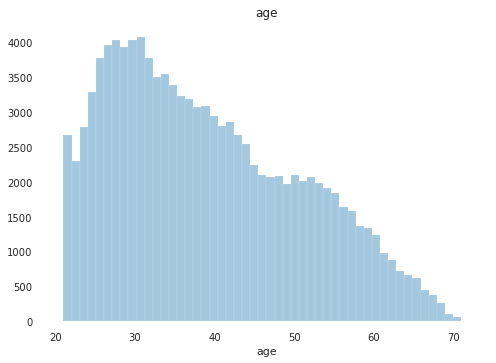

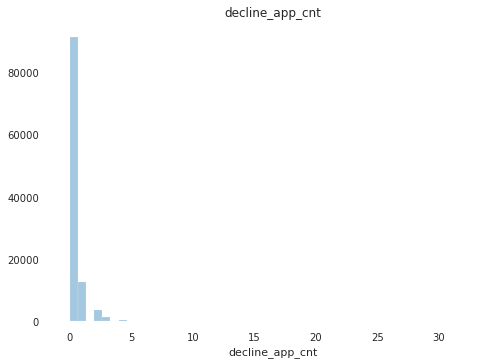

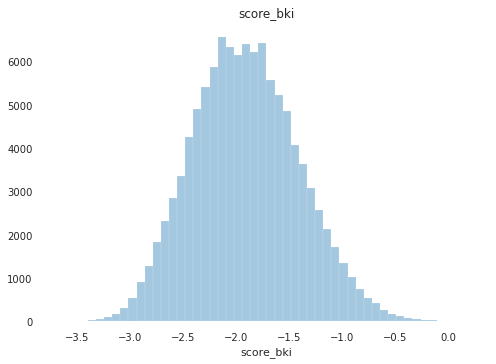

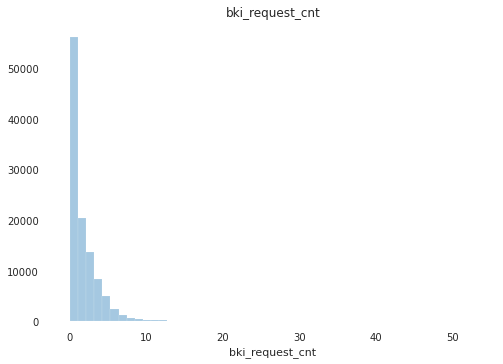

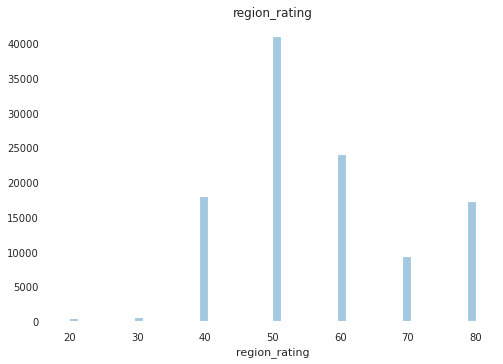

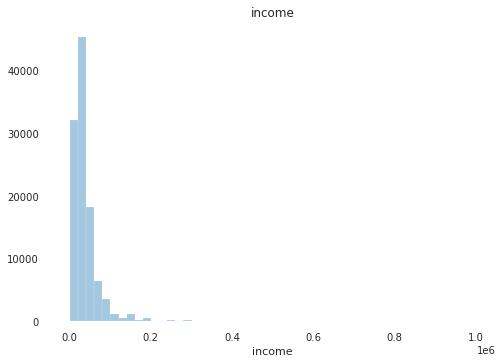

In [21]:
#анализ распределения числовых признаков
for item in num_var:
    plt.figure()
    sns.distplot(df[item], kde = False, rug=False)
    plt.title(item)
    plt.show()

In [22]:
#преобразования значений score_bki  
df['score_bki'] = df['score_bki'].apply(np.abs)
df[num_var].describe()

age  decline_app_cnt      score_bki  bki_request_cnt  \
count  110148.000000    110148.000000  110148.000000    110148.000000   
mean       39.249410         0.273205       1.904561         2.005002   
std        11.518063         0.799099       0.499297         2.266926   
min        21.000000         0.000000       0.006805         0.000000   
25%        30.000000         0.000000       1.567888         0.000000   
50%        37.000000         0.000000       1.920823         1.000000   
75%        48.000000         0.000000       2.260434         3.000000   
max        72.000000        33.000000       3.624586        53.000000   

       region_rating          income  
count  110148.000000   110148.000000  
mean       56.751189    41012.648537  
std        13.065923    45399.735051  
min        20.000000     1000.000000  
25%        50.000000    20000.000000  
50%        50.000000    30000.000000  
75%        60.000000    48000.000000  
max        80.000000  1000000.000000

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


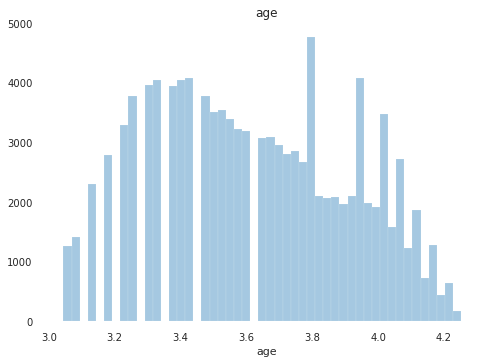

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


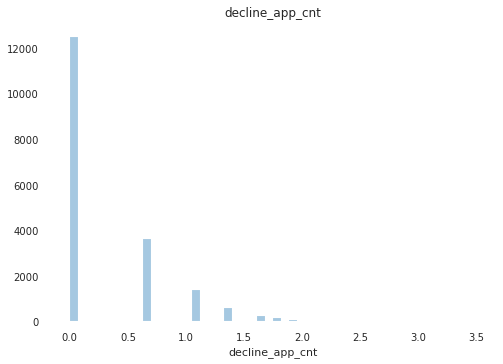

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


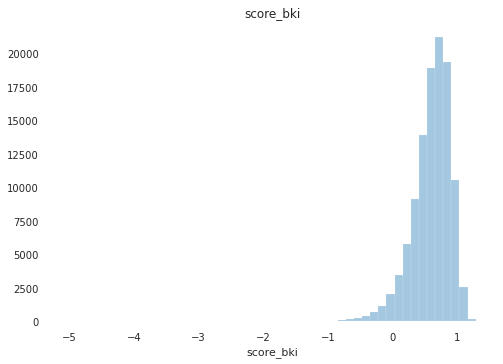

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


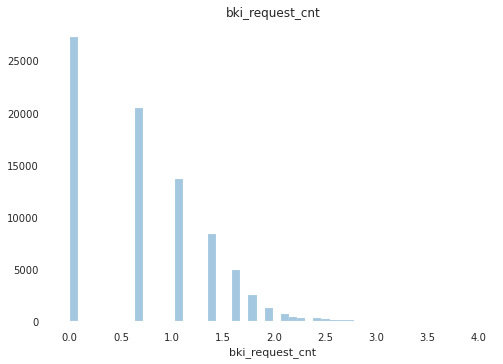

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


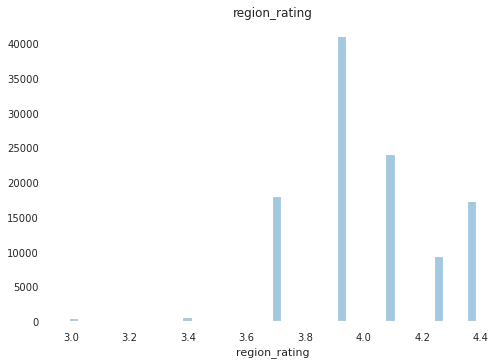

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


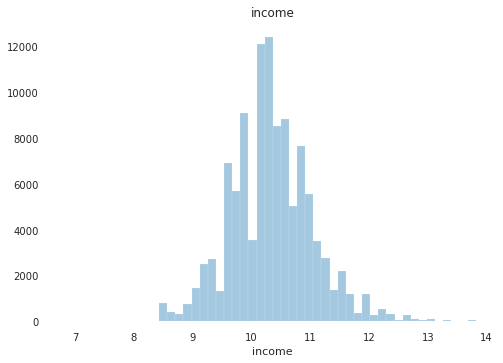

In [23]:
#анализ распределения логорифмированных числовых признаков
for item in num_var:
    plt.figure()
    sns.distplot(np.log(df[item][df[item] > 0].dropna()), kde = False, rug=False)
    plt.title(item)
    plt.show()

In [24]:
#логорифмируем числовые признаки для лучшей нормализации
for item in num_var:
    df[item] = df[item].apply(lambda x: np.log(x) if x>0 else x)

In [25]:
#стандартизация числовых признаков
ss = StandardScaler()
ss.fit(df[num_var])
X_num = ss.transform(df[num_var]) #формирование конечной матрицы числовых признаков

# 5. Произведем комбинирование признаков различных типов для дальнейшего обучения модели на них и получения результатов из тестовой выборки. 

In [26]:
# объединение всех признаков в единую матрицу
X = np.hstack([X_num, X_cat, X_bool])

In [27]:
# выделяем выборку для обучения модели с равным распределением целевого параментра
X_Train = X[:18744,:]
y_Train = df[df['test']==0]['default'].values[:18744]

# 6. Деление обучающей выборки

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X_Train, y_Train, test_size=0.3, shuffle=True, random_state=RANDOM_STATE)

# 7. Обучение модели и предсказание целевых параметров

In [29]:
model = LogisticRegression()
model.fit(X_train, Y_train)
Y_pred_proba = model.predict_proba(X_test)[:,1]
Y_pred = model.predict(X_test)

# 8. Расчет и анализ метрик для оценки модели.

In [30]:
#ROC AUC metrics
roc_auc_score(Y_test, Y_pred_proba)

0.7389434885549843

In [31]:
# confusion matrix
confusion_matrix(Y_test, Y_pred, labels=[1,0])

array([[1884,  883],
       [ 942, 1915]])

In [32]:
#f1 Score metric
f1_score(Y_test, Y_pred, zero_division=1)

0.6736992669408189

# 9. Получение целевых данных из тестовой выборки

In [33]:
#выделение тестовой выборки
X_target = X[73799:,:]
#получение результата
y_pred_proba = model.predict_proba(X_target)[:,1]


In [34]:
#запись результатов
submission = pd.DataFrame(
    {"client_id": test_df['client_id'] , "default": y_pred_proba})
submission.to_csv("submission.csv", index=False)
submission.head()

client_id   default
0      74835  0.216643
1      17527  0.800468
2      75683  0.288970
3      26883  0.424567
4      28862  0.181030